<a href="https://colab.research.google.com/github/ageryw/MosquitoClassification/blob/main/MosquitoAlertProMod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **K-Fold Cross-Validation**

## **Vgg16**

In [ ]:
!unzip Mosq1.zip

In [ ]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import KFold
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
from math import sqrt

writer = SummaryWriter()

In [ ]:
!rm Mosq1.zip

In [ ]:
# Configuration options
k_folds = 5
num_epochs = 10
criterion = nn.CrossEntropyLoss()

# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(42)
data_transforms = transforms.Compose([
    transforms.Resize(256)
    transforms.CenterCrop(224),
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = 'Mosq/'
dataset = datasets.ImageFolder(data_dir, data_transforms)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=30, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=30, sampler=test_subsampler)
    model_ft = models.vgg16(pretrained=True)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, 2)
    model_ft = model_ft.to(device)
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.7)
    for epoch in range(0, num_epochs):
        # Print epoch
        print(f'Epoch {epoch+1}')
        # Set current loss value
        current_loss = 0.0
        running_corrects = 0
        tcorrect, ttotal = 0, 0
        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader):
            # Get inputs
            inputs, targets = data
            inputs, targets = inputs.cuda(), targets.cuda()
            # Zero the gradients
            optimizer_ft.zero_grad()
            # Perform forward pass
            outputs = model_ft(inputs)
            _, preds = torch.max(outputs.data, 1)
            # Compute loss
            loss = criterion(outputs, targets)
            # Perform backward pass
            loss.backward()
            # Perform optimization
            optimizer_ft.step()
            # Print statistics
            #=======================================
            current_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == targets.data)
            ttotal += targets.size(0)
            tcorrect += (preds == targets).sum().item()
            #running_corrects += (preds == targets).sum().item()
        epoch_loss = current_loss / ttotal
        epoch_acc = running_corrects.double() / ttotal
        tacc = tcorrect / ttotal
        print(f'Train Loss: {epoch_loss:.3f}, Train Acc: {epoch_acc:.3f}, TrainAcc2:{tacc:.3f}')

        writer.add_scalar(f'Runs/train/loss/fold{fold}', epoch_loss, epoch)
        writer.add_scalar(f'Runs/train/Acc/fold{fold}', epoch_acc, epoch)
        correct, total = 0, 0
        vcurrent_loss = 0.0
        vrunning_corrects = 0
        with torch.no_grad():
            # Iterate over the test data and generate predictions
            for i, data in enumerate(testloader, 0):
                # Get inputs
                inputs, targets = data
                inputs, targets = inputs.cuda(), targets.cuda() 
                # Generate outputs
                outputs = model_ft(inputs)
                # Set total and correct
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, targets)
                total += targets.size(0)
                correct += (preds == targets).sum().item()
                vcurrent_loss += loss.item() * inputs.size(0)
                vrunning_corrects += torch.sum(preds == targets.data)
            epoch_loss = vcurrent_loss / total
            epoch_acc = vrunning_corrects.double() / total
            vtotal = correct / total
            print(f'Val Loss: {epoch_loss:.3f}, Val Acc: {epoch_acc:.3f}, Val Acc2: {vtotal:.3f}')

            writer.add_scalar(f'Runs/val/loss/fold{fold}', epoch_loss, epoch)
            writer.add_scalar(f'Runs/val/Acc/fold{fold}', epoch_acc, epoch)

    save_path = f'./model-fold-{fold}.pth'
    torch.save(model_ft.state_dict(), save_path)
    results[fold] = 100.0 * (correct / total)

print('--------------------------------')
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/

## **ResNet50**

In [ ]:
!unzip Mosq.zip

In [ ]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import KFold
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
from math import sqrt

writer = SummaryWriter()

In [ ]:
!rm Mosq1.zip

In [ ]:
# Configuration options
k_folds = 5
num_epochs = 10
criterion = nn.CrossEntropyLoss()

# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(42)
data_transforms = transforms.Compose([
    transforms.Resize(256)
    transforms.CenterCrop(224),
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = 'Mosq/'
dataset = datasets.ImageFolder(data_dir, data_transforms)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=30, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=30, sampler=test_subsampler)
    
    model_ft = models.resnet50(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 2)
    model_ft = model_ft.to(device)
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.7)
    for epoch in range(0, num_epochs):
        # Print epoch
        print(f'Epoch {epoch+1}')
        # Set current loss value
        current_loss = 0.0
        running_corrects = 0
        tcorrect, ttotal = 0, 0
        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader):
            # Get inputs
            inputs, targets = data
            inputs, targets = inputs.cuda(), targets.cuda()
            # Zero the gradients
            optimizer_ft.zero_grad()
            # Perform forward pass
            outputs = model_ft(inputs)
            _, preds = torch.max(outputs.data, 1)
            # Compute loss
            loss = criterion(outputs, targets)
            # Perform backward pass
            loss.backward()
            # Perform optimization
            optimizer_ft.step()
            # Print statistics
            #=======================================
            current_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == targets.data)
            ttotal += targets.size(0)
            tcorrect += (preds == targets).sum().item()
            #running_corrects += (preds == targets).sum().item()
        epoch_loss = current_loss / ttotal
        epoch_acc = running_corrects.double() / ttotal
        tacc = tcorrect / ttotal
        print(f'Train Loss: {epoch_loss:.3f}, Train Acc: {epoch_acc:.3f}, TrainAcc2:{tacc:.3f}')

        writer.add_scalar(f'Runs/train/loss/fold{fold}', epoch_loss, epoch)
        writer.add_scalar(f'Runs/train/Acc/fold{fold}', epoch_acc, epoch)
        correct, total = 0, 0
        vcurrent_loss = 0.0
        vrunning_corrects = 0
        with torch.no_grad():
            # Iterate over the test data and generate predictions
            for i, data in enumerate(testloader, 0):
                # Get inputs
                inputs, targets = data
                inputs, targets = inputs.cuda(), targets.cuda() 
                # Generate outputs
                outputs = model_ft(inputs)
                # Set total and correct
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, targets)
                total += targets.size(0)
                correct += (preds == targets).sum().item()
                vcurrent_loss += loss.item() * inputs.size(0)
                vrunning_corrects += torch.sum(preds == targets.data)
            epoch_loss = vcurrent_loss / total
            epoch_acc = vrunning_corrects.double() / total
            vtotal = correct / total
            print(f'Val Loss: {epoch_loss:.3f}, Val Acc: {epoch_acc:.3f}, Val Acc2: {vtotal:.3f}')

            writer.add_scalar(f'Runs/val/loss/fold{fold}', epoch_loss, epoch)
            writer.add_scalar(f'Runs/val/Acc/fold{fold}', epoch_acc, epoch)

    save_path = f'./model-fold-{fold}.pth'
    torch.save(model_ft.state_dict(), save_path)
    results[fold] = 100.0 * (correct / total)

print('--------------------------------')
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/

# **Generate Confusion Martix**

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2355  344]
 [  64 2340]]


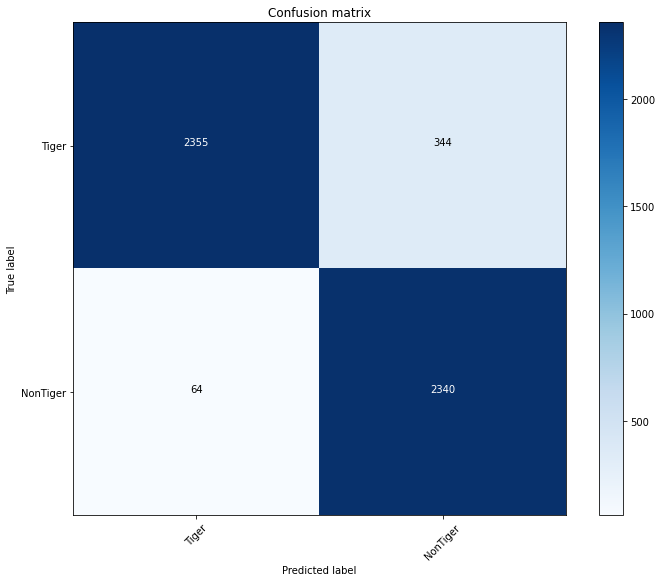

In [ ]:
from sklearn.metrics import confusion_matrix
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

cm = confusion_matrix(lbllist.numpy(), predlist.numpy())

#import seaborn as sns

#names = ('AeAl', 'NoAeAl')
plt.figure(figsize=(10,8))
#sns.heatmap(confusion_matrix(testGen.classes, y_pred), annot=True, fmt="d")
#sns.heatmap(confusion_matrix(testGen.classes, names), annot=True, fmt="d")
names = (
    'Tiger'
    ,'NonTiger'
)

plot_confusion_matrix(cm, names)

In [ ]:
print(classification_report(lbllist.numpy(), predlist.numpy()))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      2699
           1       0.87      0.97      0.92      2404

    accuracy                           0.92      5103
   macro avg       0.92      0.92      0.92      5103
weighted avg       0.93      0.92      0.92      5103



In [ ]:
!zip -r runs.zip runs

  adding: runs/ (stored 0%)
  adding: runs/Mar15_11-23-51_71103b93e0fd/ (stored 0%)
  adding: runs/Mar15_11-23-51_71103b93e0fd/events.out.tfevents.1615807432.71103b93e0fd.994.0 (deflated 67%)


# **Generate Grad-Cam Explanation**

In [ ]:
from collections import OrderedDict

import numpy as np
import torch
import cv2
from torch.nn import functional as F

        

In [ ]:
# -- GradCAM --
# Author:   Kazuto Nakashima
# URL:      http://kazuto1011.github.io
# Created:  2017-05-26

def normalize(input):
    output = (input - np.min(input)) / (np.max(input) - np.min(input))
    return output


In [ ]:

def save_gradient(filename, data):
    data -= data.min()
    data /= data.max()
    data *= 255.0
    cv2.imwrite(filename, np.uint8(data))

In [ ]:
def save_gradcam(filename, gcam, raw_image):
    
    h, w, _ = raw_image.shape
    gcam = cv2.resize(gcam, (w, h))
    
    gcam = cv2.applyColorMap(np.uint8(gcam * 255.0), cv2.COLORMAP_JET)
    #cv2.imshow(gcam)
    
    gcam = gcam.astype(np.float) + raw_image.astype(np.float)
    gcam = gcam / gcam.max() * 255.0
    cv2.imwrite(filename, np.uint8(gcam))
    cv2.rectangle(gcam,(384,0),(510,128),(0,255,0),3)
    plt.imshow(np.uint8(gcam))
    plt.show()

In [ ]:
def save_raw_image(filename, raw_image):
    cv2.imwrite(filename, np.uint8(raw_image))

In [ ]:
class _PropagationBase(object):
    def __init__(self, model):
        super(_PropagationBase, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.image = None

    def _encode_one_hot(self, idx):
        one_hot = torch.FloatTensor(1, self.preds.size()[-1]).zero_()
        one_hot[0][idx] = 1.0
        return one_hot.to(self.device)

    def forward(self, image):
        self.image = image.requires_grad_()
        self.model.zero_grad()
        self.preds = self.model(self.image)
        self.probs = F.softmax(self.preds, dim=1)[0]
        self.prob, self.idx = self.probs.sort(0, True)
        return self.prob, self.idx

    def backward(self, idx):
        one_hot = self._encode_one_hot(idx)
        self.preds.backward(gradient=one_hot, retain_graph=True)

In [ ]:
class GradCAM(_PropagationBase):
    def __init__(self, model):
        super(GradCAM, self).__init__(model)
        self.all_fmaps = OrderedDict()
        self.all_grads = OrderedDict()

        def func_f(module, input, output):
            self.all_fmaps[id(module)] = output.detach()

        def func_b(module, grad_in, grad_out):
            self.all_grads[id(module)] = grad_out[0].detach()

        for module in self.model.named_modules():
            module[1].register_forward_hook(func_f)
            module[1].register_backward_hook(func_b)

    def _find(self, outputs, target_layer):
        for key, value in outputs.items():
            for module in self.model.named_modules():
                if id(module[1]) == key:
                    if module[0] == target_layer:
                        return value
        raise ValueError('Invalid layer name: {}'.format(target_layer))

    def _normalize(self, grads):
        l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
        return grads / l2_norm

    def _compute_grad_weights(self, grads):
        grads = self._normalize(grads)
        return F.adaptive_avg_pool2d(grads, 1)

    def generate(self, target_layer):
        fmaps = self._find(self.all_fmaps, target_layer)
        grads = self._find(self.all_grads, target_layer)
        weights = self._compute_grad_weights(grads)
        gcam = (fmaps[0] * weights[0]).sum(dim=0)
        
        gcam = torch.clamp(gcam, min=0.)

        gcam -= gcam.min()
        gcam /= gcam.max()
        return gcam.detach().cpu().numpy()

In [ ]:
from torchvision import models, transforms
from torch.autograd import Variable
from PIL import Image
import os


In [ ]:
weights ='model.pth'#Pre-trained weight file (*.pth)
input = 'images/002842.png'#Directory for an input image
output = 'gradcams'#Directory for the visualization result

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classes = ["Tiger", "Non-tiger"]

if (os.path.isdir(output)):
    print('Output directory exists')
else:
    os.mkdir(output)

model = models.vgg16(pretrained=True)
model.classifier[6] = torch.nn.Linear(4096,2)
#model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(weights))
#model = model.module
model.eval()
model.to(device)

data_transforms = transforms.Compose([
    transforms.ToTensor()
])

### Target layers (VGG16)
targets = [
    "features.0",
    "features.2",
    "features.4",
    "features.5",
    "features.7",
    "features.10",
    "features.12",
    "features.14",
    "features.17",
    "features.19",
    "features.21",
    "features.24",
    "features.26",
    "features.28",
    "features.30",
]
### Target layers (VGG19)
'''
targets = [
    "features.0",
    "features.2",
    "features.5",
    "features.7",
    "features.10",
    "features.12",
    "features.14",
    "features.16",
    "features.19",
    "features.21",
    "features.23",
    "features.25",
    "features.28",
    "features.30",
    "features.32",
    "features.34",
    "features.36",
]
'''
image_num = 0
input_image = input

# =========================================================================
print('='*20)
# =========================================================================

print(f"Processing image \'{input_image}\'")

raw_image = cv2.imread(input_image)[..., ::-1]
im_pil = Image.fromarray(raw_image)

image = data_transforms(im_pil).unsqueeze(0)
image_var = Variable(image)

a = transforms.ToPILImage()(image.squeeze())

tr_image = np.asarray(np.transpose(image.squeeze(0),(1,2,0)))
tr_image = cv2.cvtColor(tr_image,cv2.COLOR_BGR2RGB)
tr_image = np.uint8(normalize(tr_image)*255)
image_name = input_image.split(sep="/")[-1].split(sep=".")[-2]
save_dir = os.path.join(output,image_name)
if(os.path.isdir(save_dir)):
    print('Save directory exists')
else:
    os.mkdir(save_dir)
print('Visualization saved to : ',save_dir)

a.save(os.path.join(save_dir,'_input_image'+'.jpg'))
gcam = GradCAM(model=model)
print('-------------------')
print(gcam)
probs, idx = gcam.forward(image_var.to(device))

print("-"*30)
print("|  Probability  |    Class   |")
print("-"*30)
for i in range(0, 2):
    for j in range(0,len(targets)):
        gcam.backward(idx=idx[i])
        output = gcam.generate(target_layer=targets[j])
        # Filename : {ClassName}_gcam_{NumLayer}
        save_gradcam(save_dir+'/{}_gcam_{}.png'.format(classes[idx[i]], targets[j]), output, tr_image)
    print('[{:.5f}] {}'.format(probs[i], classes[idx[i]]))


In [ ]:
!zip -r gradcams.zip gradcams/

# **Fine-Tuning (VGG16 and ResNet50)-**

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import classification_report
import numpy as np

plt.ion() 

In [ ]:
!unzip Mosq.zip

In [ ]:
!rm Mosq.zip

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256)
        transforms.CenterCrop(224),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.643, 0.661, 0.634], [0.202, 0.204, 0.205])
    ]),
}

data_dir = 'Mosq/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
n_epochs = 25
print_every = 10
val_loss = []
val_acc = []
train_loss = []
train_acc = []
############
test_acc = []
test_loss = []
##############
predlist=[]
lbllist=[]
#===========
##############
tpredlist=[]
tlbllist=[]
#=========
trstd = []
vlstd = []


In [ ]:
from torch.utils.tensorboard import SummaryWriter
from math import sqrt

writer = SummaryWriter()

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #stdtr_temp = []
    #stdvl_temp = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                curr_train_samples = preds.size(0)

            #================================================
            predlist.append(preds.view(-1).cpu())
            lbllist.append(labels.view(-1).cpu())
            #=================================================
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                #stdtr_temp.append(epoch_acc)
                writer.add_scalar(f'Runs/Loss/train', epoch_loss, epoch)
                writer.add_scalar(f'Runs/Accuracy/train', epoch_acc, epoch)
            if phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                #stdvl_temp.append(epoch_acc)
                writer.add_scalar(f'Runs/Loss/val', epoch_loss, epoch)
                writer.add_scalar(f'Runs/Accuracy/val', epoch_acc, epoch)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            '''if epoch%2 == 0 and epoch != 0:
                trstd.append(np.std(stdtr_temp))
                vlstd.append(np.std(stdvl_temp))
                stdtr_temp = []
                stdvl_temp = []'''

        print()
    #Calculating conffidence
    tavg_acc = sum(train_acc)/len(train_acc)
    vavg_acc = sum(val_acc)/len(val_acc)

    cinterval_train = 1.96 * sqrt( (tavg_acc * (100 - tavg_acc)) / dataset_sizes['train'])
    print(f'Train Confidence Interval:{cinterval_train:3f}')
    cinterval_val = 1.96 * sqrt( (vavg_acc * (100 - vavg_acc)) / dataset_sizes['val'])
    print(f'Validation Confidence Interval:{cinterval_val:3f}')
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    print(f'Average Training Accuracy:{tavg_acc:3f}')
    print(f'Average Validation  Accuracy:{vavg_acc:3f}')
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.vgg16(pretrained=True)
#num_ftrs = model_ft.classifier[0].out_features
num_ftrs = model_ft.classifier[6].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[6] = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.7)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
#ResNet50- To train on ResNet50 uncomment this section and comment the Vgg16 section.
'''model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
# Save the model
torch.save(model_ft,'model.h5')

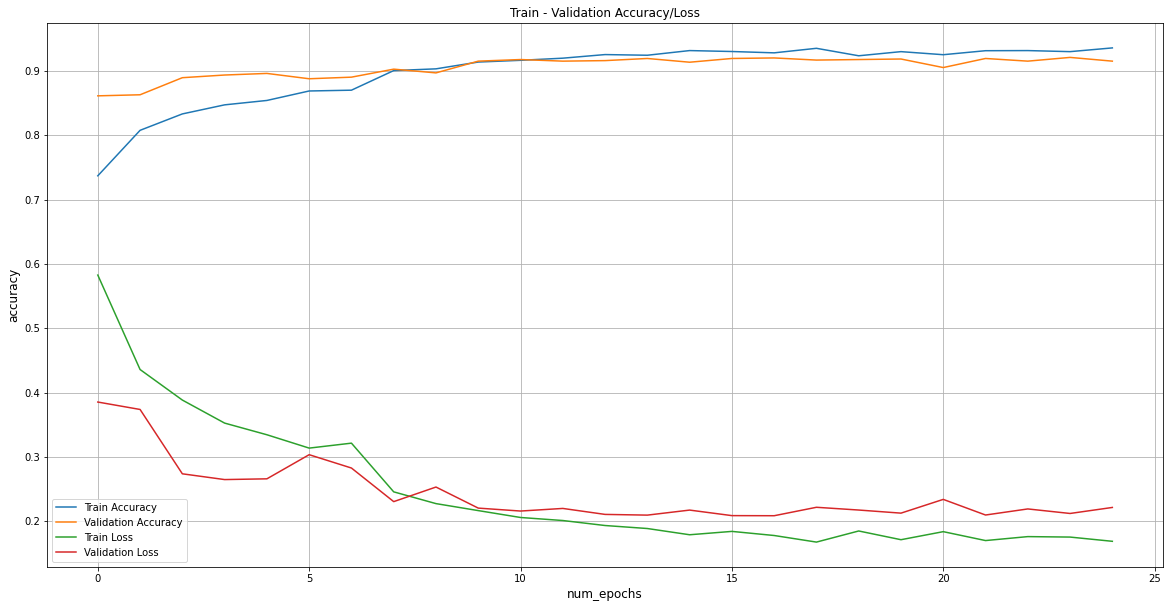

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy/Loss")
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot( train_loss, label='Train Loss')
plt.plot( val_loss, label='Validation Loss')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/

In [ ]:
!zip -r runs.zip runs/

  adding: runs/ (stored 0%)
  adding: runs/Mar12_15-02-00_efc66d46f809/ (stored 0%)
  adding: runs/Mar12_15-02-00_efc66d46f809/events.out.tfevents.1615561321.efc66d46f809.58.0 (deflated 67%)


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
import torch.nn.functional as nnf

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            #=======================================
            prob = nnf.softmax(outputs, dim=1)
            top_p, top_class = prob.topk(1, dim = 1)
            #=======================================
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                fig = plt.figure(figsize=(10,10))
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                #=======================================
                toppr = top_p[j]*100
                topprnp = toppr.cpu().numpy()
                conv = np.around(topprnp, decimals=2)

                ax.set_title('{}% {}'.format(conv, class_names[preds[j]]))
                #=======================================
                
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model_ft)

In [ ]:
from torch.autograd import Variable

def test(model,dataloader,device,batch_size):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    #================
    prob = []
    #================
    sm = nn.Softmax(dim = 1)
    criterion = nn.CrossEntropyLoss()

    for batch_idx, (data, target) in enumerate(dataloaders['test']):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.FloatTensor).to(device)
        target = target.type(torch.LongTensor).to(device)
        model.eval()
        output = model(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        #=======================================
        top_p, top_class = output.topk(1, dim = 1)
        #=======================================
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
  
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
                #=================
                toppr = top_p[i]*100
               #print(toppr.type)
                #print(toppr)
                topprnp = toppr.detach()
                topprnp = topprnp.cpu().numpy()
                conv = np.around(topprnp, decimals=2)
                prob.append(conv)
                #==================
    #problst = [t.numpy() for t in prob]
    epoch_acc = running_corrects.double()/(len(dataloaders['test'])*batch_size)
    test_acc.append(epoch_acc)
    epoch_loss = running_loss/(len(dataloaders['test'])*batch_size)
    test_loss.append(epoch_loss)
    print('Testset Accuracy {}'.format(epoch_acc))
    print('Testset Loss {}'.format(epoch_loss))
    return true,pred,image,true_wrong,pred_wrong, prob

In [ ]:
model_ft = torch.load('model.h5')
true,pred,image,true_wrong,pred_wrong, probl= test(model_ft, dataloaders['test'], device,batch_size=4)
#model.eval()

Testset Accuracy 0.9
Testset Loss 0.3372337210012807


In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Test Accuracy/Loss")
plt.plot(test_acc, label='Testin Accuracy')
plt.plot( test_loss, label='Test Loss')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
import random
import scipy.misc
from PIL import Image

p = 'cl/'
def wrong_plot(n_figures,true,ima,pred,encoder,inv_normalize, probl):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    i=0
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)

        image,correct,wrong, probabl = ima[a],true[a],pred[a], probl[a][0]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        #f = 'A:'+c + ',' +'P:'+w
        #======================
        f = 'A:'+c + ',' +'P:'+w+" "+ str(probabl)+"%"
        #======================
        if inv_normalize !=None:
            image = inv_normalize(image)

        image = image.numpy().transpose(1,2,0)
        i += 1
        #cv2.imwrite(os.path.join(p, c+str(i)+'.png'), image)
        if c == 'NotAeAl':
          plt.axis('off')
          plt.title(c+'->'+w +" "+ str(probabl)+"%")
          plt.imshow(image)
          plt.show()
        #im = ax.imshow(image)
      #  ax.set_title(f)
     #   ax.axis('off')
    #plt.show()

In [ ]:
#probnp = [t.numpy() for t in probl]
wrong_plot(12, true_wrong, image, pred_wrong, encoder, inv_normalize, probl)